## Описание задачи

Металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого нужно контролировать температуру сплава. Надо построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Надо сохранить смысловую нагрузку в признаках.

Описание этапа обработки

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

Предсказываем последнюю измеренную температуру.

План: 

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Соединение таблиц
4. Анализ данных
5. Модель
6. Выводы

In [11]:
!pip install shap

     |████████████████████████████████| 997 kB 2.4 MB/s eta 0:00:01


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor

ImportError: cannot import name 'HistGradientBoostingRegressor' from 'sklearn.ensemble' (/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/__init__.py)

## 1. Загрузка данных

In [15]:
try:
    df_arc = pd.read_csv(r"C:\metall\data_arc_new.csv")
except:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')

try:
    df_bulk = pd.read_csv(r"C:\metall\data_bulk_new.csv")
except:
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

try:
    df_time_bulk = pd.read_csv(r"C:\metall\data_bulk_time_new.csv")
except:
    df_time_bulk = pd.read_csv('/datasets/data_bulk_time_new.csv')

try:
    df_gas = pd.read_csv(r"C:\metall\data_gas_new.csv")
except:
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')

try:
    df_temp = pd.read_csv(r"C:\metall\data_temp_new.csv")
except:
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')

try:
    df_wire = pd.read_csv(r"C:\metall\data_wire_new.csv")
except:
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')

try:
    df_wire_time = pd.read_csv(r"C:\metall\data_wire_time_new.csv")
except:
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [16]:
#Выводим таблицу и информацию о нем
def info_read(df):
    display(df.head(10))
    df.info()
    print()
    print(f'Строки-пропуски {df.isna().all(axis=1).sum()}')
    print(f'Полные дубликаты {df_arc.duplicated().sum()}')
    return 

In [17]:
info_read(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Строки-пропуски 0
Полные дубликаты 0


Пропусков нет. Столбцы с временем можно превратить во временные промежутки.

In [18]:
info_read(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Строки-пропуски 0
Полные дубликаты 0


Пропусков нет. Значение в том или ином столбце указывает, откуда какие емкости использовались при загрузке. Сумма

In [19]:
info_read(df_time_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Строки-пропуски 0
Полные дубликаты 0


Вряд ли таблица полезна.

In [20]:
info_read(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Строки-пропуски 0
Полные дубликаты 0


Из газа можно поделать новые признаки. Пропусков нет.

In [21]:
info_read(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Строки-пропуски 0
Полные дубликаты 0


In [22]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Температура указана как многократное снятие показаний в течение процесса отлива стали. Целевая температура - последняя. Единственную температуру в ключе буду считать целевой.

In [23]:
info_read(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Строки-пропуски 0
Полные дубликаты 0


Суммирование по строкам даст общее количество поданного проволочного материала.

In [24]:
info_read(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Строки-пропуски 0
Полные дубликаты 0


Можно было бы создать столбец с длительностью подачи, но указано только время начала. Выглядит бесполезно.

Датафреймы разного объема, явных пропусков нет, полных дубликатов нет. Названия столбцов надо привести к общему виду


## 2. Исследовательский анализ и предобработка данных

In [25]:
#Построение boxplot с подсчетом количества выбросов
def box(df):
    boxplot = plt.boxplot(df)
    boxplot
    outliers = list(boxplot["fliers"][0].get_data()[1])
    print(f'Выбросов: {len(outliers)} из {len(df)}') 

In [26]:
#Гистограмма
def distrib(df):
    sns.histplot(x=df, kde=True)
    plt.title(f'Гистограмма по столбцу {df.name}')
    plt.ylabel('Количество')
    plt.xlabel(f'Распределение величины {df.name}')

### Анализ таблиц по отдельности:

#### 1. Таблица *df_arc*

In [27]:
display(df_arc.head(15))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [28]:
#Столбец с длительностью нагрева
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_arc['heat_time'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.total_seconds()

In [29]:

df_arc = df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis = 1)

In [30]:
df_arc = df_arc.rename(columns={'Активная мощность': 'p', 'Реактивная мощность': 'q'})

In [31]:
display(df_arc.describe())

,key,p,q,heat_time
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986,171.670946
std,934.571502,0.258885,5.873485,98.186803
min,1.000000,0.223120,-715.479924,11.000000
25%,806.000000,0.467115,0.337175,107.000000
50%,1617.000000,0.599587,0.441639,147.000000
75%,2429.000000,0.830070,0.608201,214.000000
max,3241.000000,1.463773,1.270284,907.000000


Явный выброс в `Реактивной мощности`

In [32]:
df_arc.query('q < 0')

,key,p,q,heat_time
9780,2116,0.705344,-715.479924,109.0


Отрицательная реактивная мощность не имеет физического смысла, датчик мог считать в других единицах измерения, система может своеобразно считывать потоки энергии и тд. Допустим, что забыли поделить на 1000 и взять модуль:

In [33]:
df_arc['q'] = df_arc['q'].replace(-715.479924, -715.479924 / -1000)

In [34]:
#Полная мощность
df_arc['s'] = np.sqrt(df_arc['p']**2 + df_arc['q']**2)

Выбросов: 72 из 14876


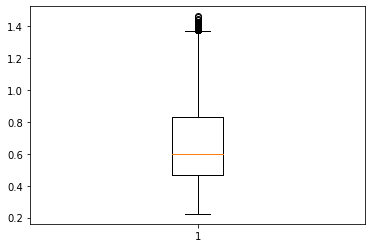

In [35]:
box(df_arc['p'])

Выбросов: 198 из 14876


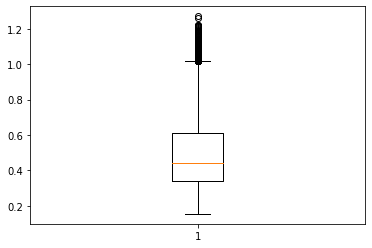

In [36]:
box(df_arc['q'])

Выбросов: 617 из 14876


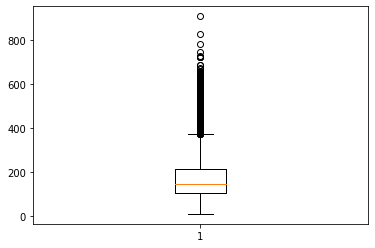

In [37]:
box(df_arc['heat_time'])

Выбросы локализованы близко к 3 квантилю кроме столбца `heat_time`

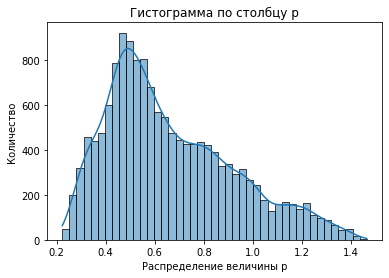

In [38]:
distrib(df_arc['p'])

Левосторонняя ассиметрия.

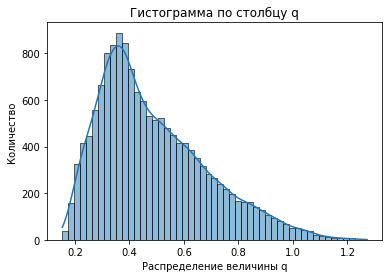

In [39]:
distrib(df_arc['q'])

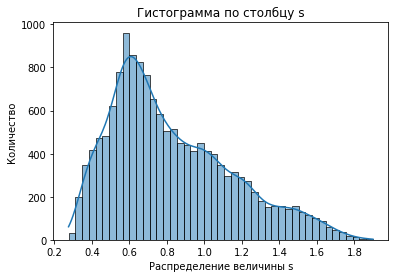

In [40]:
distrib(df_arc['s'])

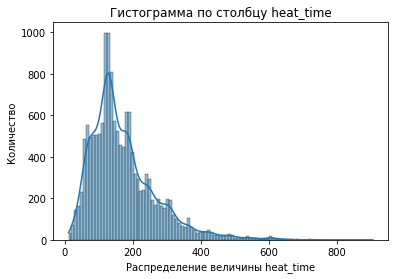

In [41]:
distrib(df_arc['heat_time'])

In [42]:
display(df_arc.head(10))

,key,p,q,heat_time,s
0,1,0.305130,0.211253,228.0,0.371123
1,1,0.765658,0.477438,185.0,0.902319
2,1,0.580313,0.430460,172.0,0.722536
3,1,0.518496,0.379979,365.0,0.642824
4,1,0.867133,0.643691,148.0,1.079934
5,2,0.381124,0.220351,137.0,0.440239
6,2,0.261665,0.205527,338.0,0.332731
7,2,0.710297,0.484962,126.0,0.860064
8,2,0.786322,0.542517,210.0,0.955315
9,3,1.101678,0.820856,280.0,1.373863


Исправлен один выброс, переименованы столбцы, добавлены новыe признаки: `heat_time` - время работы дуги, `s`. Выбросов мало и локализованы они недалеко от третьего квантиля. Мощности сильно коррелируют. Что-то потом можно удалить.

#### 2. Таблица *df_bulk*:

In [43]:
display(df_bulk.head(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Считаем суммарное количество материала и количество источников:

In [44]:
df_bulk['bulk'] = df_bulk.drop('key', axis = 1).sum(axis=1)
df_bulk['bulk_count'] = df_bulk.drop('key', axis = 1).count(axis=1)

In [45]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk,bulk_count
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000,3129.000000,3129.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345,595.503356,4.566315
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319,276.557794,1.216165
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000,19.000000,2.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000,429.000000,4.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000,591.000000,5.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000,772.000000,5.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,8.000000


Выбросов: 21 из 3129


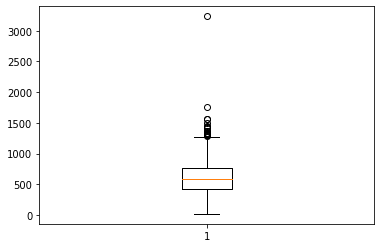

In [46]:
box(df_bulk['bulk'])

Выброс всего один.

Выбросов: 368 из 3129


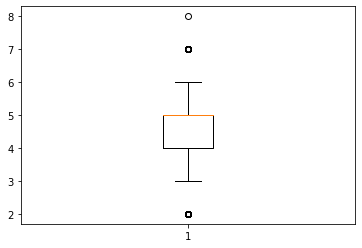

In [47]:
box(df_bulk['bulk_count'])

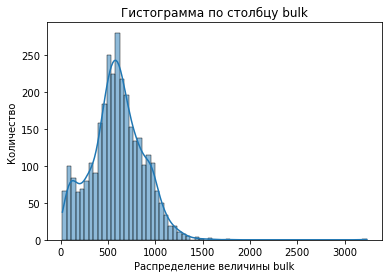

In [48]:
distrib(df_bulk['bulk'])

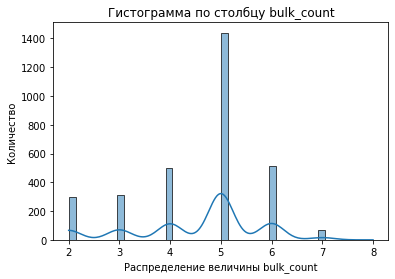

In [49]:
distrib(df_bulk['bulk_count'])

В обоих признаках данные распределены близко к нормальному распределению.

Из-за дискретности 10% ушло в выбросы.

In [50]:
df_bulk = df_bulk.drop(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',	'Bulk 5', 'Bulk 6',	'Bulk 7', 'Bulk 8',	'Bulk 9', 'Bulk 10', 'Bulk 11',	'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'], axis = 1)

Создано два признака: `bulk` - общее количество материала, `bulk_count` - количество "источников", подающих материал. Номерные столбцы удалены. Распределения значений близко к нормальному. Есть незначительное количество выбросов.

#### 3. Таблица  *df_time_bulk*:

In [51]:
display(df_time_bulk.sample(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2070,2142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-28 23:18:32,NaN,NaN,NaN
2369,2456,2019-08-08 23:54:19,NaN,2019-08-08 23:54:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-08 23:54:19,NaN,2019-08-08 23:54:19,2019-08-08 23:54:19
2721,2824,NaN,NaN,2019-08-22 17:46:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
848,884,NaN,NaN,2019-06-06 20:06:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 20:06:53,NaN,2019-06-06 20:25:18,2019-06-06 20:06:53
266,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-14 14:10:18,NaN,NaN,2019-05-14 14:24:01,NaN,2019-05-14 14:21:02,NaN
2222,2302,NaN,NaN,2019-08-03 10:01:13,2019-08-03 09:58:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232,1282,NaN,NaN,2019-06-20 20:05:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-20 20:05:44,NaN,2019-06-20 20:18:50,2019-06-20 20:13:24
163,177,NaN,NaN,NaN,2019-05-10 09:55:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 09:52:52,NaN,2019-05-10 09:46:53,2019-05-10 09:41:08
1948,2016,NaN,NaN,NaN,2019-07-24 03:46:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-24 03:41:35,NaN,2019-07-24 03:39:16,2019-07-24 03:34:30
1704,1764,NaN,NaN,2019-07-08 03:42:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-08 04:04:34,NaN,2019-07-08 04:04:34,2019-07-08 03:53:39


Не очень понятно, как интегрировать эту таблицу с остальными, потому что дугу выключают перед подачей материала и установить, например, время подачи невозможно.

#### 4. Таблица  *df_gas*:

In [52]:
display(df_gas.sample(10))

,key,Газ 1
768,771,6.414807
829,832,10.663803
2248,2251,10.177622
804,807,1.879419
1766,1769,6.400097
2463,2466,22.625892
115,116,8.171377
1262,1265,9.174237
1844,1847,13.151285
712,715,6.799714


In [53]:
display(df_gas.describe())

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [54]:
df_gas.rename(columns={'Газ 1':'gas'}, inplace=True)

Выбросов: 126 из 3239


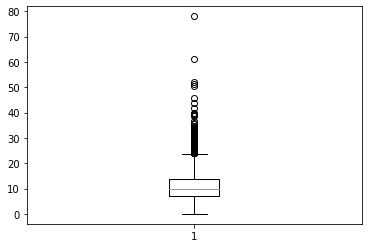

In [55]:
box(df_gas['gas'])

Изменим данные

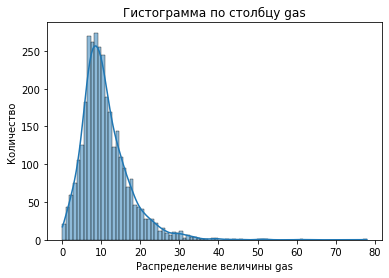

In [56]:
distrib(df_gas['gas'])

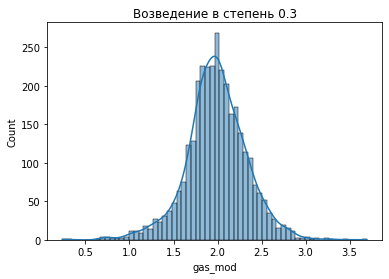

In [57]:
df_gas['gas_mod'] = (df_gas['gas']**0.3)
sns.histplot(df_gas['gas_mod'], kde=True)
plt.title('Возведение в степень 0.3')
plt.show()

In [58]:
df_temp.drop('Время замера', axis=1, inplace=True)

Небольшое количество выбросов, исправлено название столбца, добален новый признак.

#### 5. Таблица: *df_temp*

In [59]:
display(df_temp.sample(10))

,key,Температура
15148,2710,1541.0
16015,2863,NaN
8329,1490,1595.0
5318,943,1589.0
3802,679,1567.0
2587,458,1590.0
6343,1132,1587.0
7001,1253,1594.0
6622,1185,1565.0
17965,3218,NaN


In [60]:
display(df_temp.describe())

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [61]:
df_temp.rename(columns={'Температура': 'temp'}, inplace=True)

Аномальные температуры:

In [62]:
df_temp.query('temp < 1400')

,key,temp
4883,867,1191.0
6784,1214,1208.0
9050,1619,1218.0
11495,2052,1227.0
14283,2561,1204.0


In [63]:
df_temp = df_temp.query('temp > 1400')

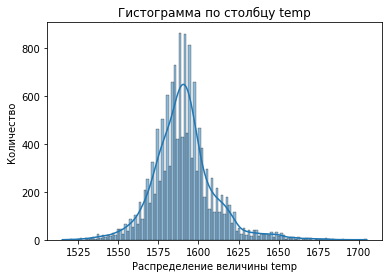

In [64]:
distrib(df_temp['temp'])

Выбросов: 830 из 14660


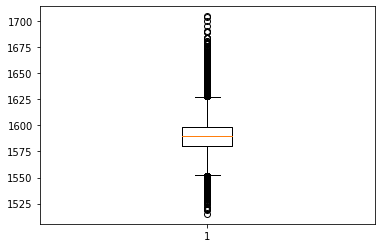

In [65]:
box(df_temp['temp'])

Возьмем первую температуру в группе и последнюю температуру в группу. Группы, где одна температура, отсеим:

In [66]:
temp_c = df_temp.groupby('key')['temp'].count()
temp_c

key
1       6
2       5
3       6
4       5
5       5
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: temp, Length: 3215, dtype: int64

In [67]:
temp_index = temp_c[temp_c > 1].index
temp_index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2489, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', name='key', length=2475)

In [68]:
first_temp = df_temp[df_temp['key'].isin(temp_index)].groupby('key').first()['temp'].reset_index().rename(columns={'temp':'first_temp'})

In [69]:
first_temp

,key,first_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
2470,2495,1570.0
2471,2496,1554.0
2472,2497,1571.0
2473,2498,1591.0


In [70]:
target_temp = df_temp.groupby('key').last()['temp'].reset_index()

In [71]:
target = first_temp.merge(target_temp, on='key', how='left')

In [72]:
target

,key,first_temp,temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


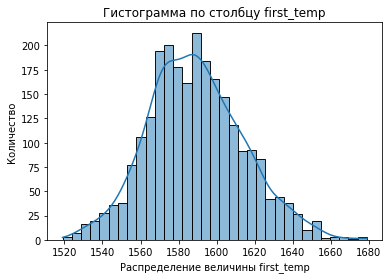

In [73]:
distrib(target['first_temp'])

Выбросов: 195 из 2475


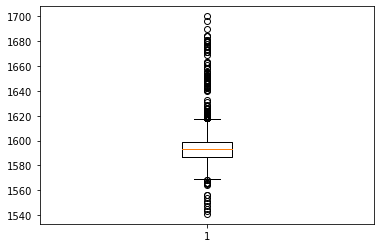

In [74]:
box(target['temp'])

Температура сосредоточена довольно кучно, за исключением одной точки. Это объяснятся режимом самого процесса. Есть небольшое количество выбросов.

#### 6. Таблица *wire*

In [75]:
display(df_wire.sample(10))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3056,3217,85.132317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2716,2862,25.159679,38.363518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2471,2598,34.201439,125.194160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2751,2904,83.166710,10.133759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,1943,63.991199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,450,221.317184,14.024400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,160,82.249435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1669,1755,115.127998,72.022079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1016,1076,99.075600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,101,76.221604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_wire['wire'] = df_wire.drop('key', axis = 1).sum(axis=1)

In [77]:
display(df_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000,3081.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752,123.723326
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616,66.082966
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800,1.918800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401,86.112000
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399,114.179523
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003,150.181198
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604,663.851766


Выбросов: 107 из 3081


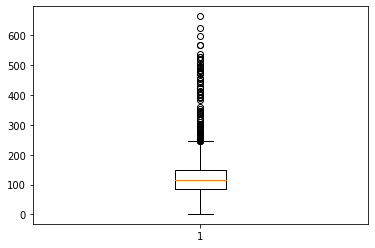

In [78]:
box(df_wire['wire'])

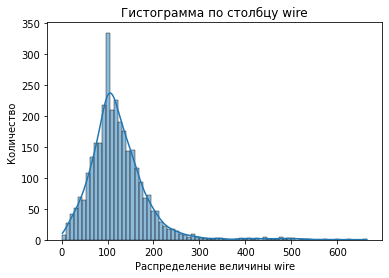

In [79]:
distrib(df_wire['wire'])

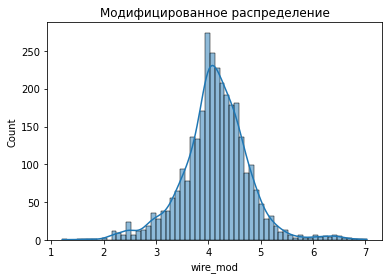

In [80]:
df_wire['wire_mod'] = df_wire['wire']**0.3
sns.histplot(df_wire['wire_mod'], kde=True)
plt.title('Модифицированное распределение')
plt.show()

In [81]:
df_wire['wire_count'] = df_wire.drop(['key', 'wire', 'wire_mod'], axis=1).count(axis=1)

In [82]:
df_wire.drop(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1, inplace=True)

Просуммированы все проволочные материалы, посчитаны источники. Выбросов мало. Создан признак `wire_mod` с распределением близким к нормальному.

#### 7. Таблица: *df_wire_time*

In [83]:
display(df_wire_time.sample(10))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2750,2903,2019-08-25 19:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2972,3131,2019-09-02 23:04:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1267,1336,2019-06-22 15:32:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,3211,2019-09-05 14:47:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1464,1540,2019-06-30 13:08:54,2019-06-30 12:56:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2735,2888,2019-08-25 01:27:32,2019-08-25 01:20:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,677,2019-05-29 19:54:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,452,2019-05-20 16:20:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,3173,2019-09-04 07:19:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2275,2399,2019-08-07 01:32:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
display(df_wire_time.describe())

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Необязательная таблица

### Выводы

1. *df_arc*: Исправлен один выброс, переименованы столбцы, добавлены новыe признаки: `heat_time` - время работы дуги, `s`. Выбросов мало и локализованы они недалеко от третьего квантиля. Что-то потом можно удалить.

2. *df_bulk*: Создано два признака: `bulk` - общее количество материала, `bulk_count` - количество "источников", подающих материал. Номерные столбцы удалены. Распределения значений близко к нормальному. Есть незначительное количество выбросов.

3. *df_bulk_time*: Не нашел применение этим данным.

4. *df_gas*: Небольшое количество выбросов, добален признак `gas_mod`, приводящий данные к нормальному распределению.

5. *df_temp*: Температура сосредоточена довольно кучно, за исключением одной точки. Это объяснятся режимом самого процесса. Есть небольшое количество выбросов. Создан целевой признак `temp` и признак по первой температуре в партии `first_temp`.

6. *df_wire*: Просуммированы все проволочные материалы, посчитаны источники. Выбросов мало. Создан признак `wire_mod` с распределением близким к нормальному.

7. *df_wire_time*: Не нашел применение этим данным.

## 3. Соединение таблиц

Самыми разными способами вытащим данные из таблицы *df_arc*:

In [85]:
arc_group = df_arc.groupby('key').agg({
    'heat_time': ['sum', 'mean', 'max', 'min'],
    'p': ['sum', 'mean', 'max'],
    'q': ['sum', 'mean', 'max'],
    's': ['sum', 'mean', 'max']
})

display(arc_group)

heat_time                               p                             q  \
           sum    mean    max    min       sum      mean       max       sum   
key                                                                            
1       1098.0  219.60  365.0  148.0  3.036730  0.607346  0.867133  2.142821   
2        811.0  202.75  338.0  126.0  2.139408  0.534852  0.786322  1.453357   
3        655.0  131.00  280.0   65.0  4.063641  0.812728  1.222963  2.937457   
4        741.0  185.25  278.0   99.0  2.706489  0.676622  0.887855  2.056992   
5        869.0  217.25  415.0   71.0  2.252950  0.563238  0.892957  1.687991   
...        ...     ...    ...    ...       ...       ...       ...       ...   
3237     909.0  181.80  242.0  119.0  2.541872  0.508374  1.090839  2.025417   
3238     546.0  182.00  265.0  111.0  1.374821  0.458274  0.623378  1.038103   
3239    1216.0  152.00  294.0   53.0  4.848005  0.606001  0.894547  3.541541   
3240     839.0  167.80  274.0  121.0  3.317679  0.663536  1.202454  2.373552   
3241     659.0  131.80  184.0   57.0  3.045283  0.609057  1.039726  2.140011   

                                 s                      
          mean       max       sum      mean       max  
key                                                     
1     0.428564  0.643691  3.718736  0.743747  1.079934  
2     0.363339  0.542517  2.588349  0.647087  0.955315  
3     0.587491  0.863676  5.019223  1.003845  1.497189  
4     0.514248  0.654661  3.400038  0.850010  1.097105  
5     0.421998  0.660807  2.816980  0.704245  1.110873  
...        ...       ...       ...       ...       ...  
3237  0.405083  0.878488  3.250657  0.650131  1.400597  
3238  0.346034  0.436618  1.723937  0.574646  0.761075  
3239  0.442693  0.613122  6.014480  0.751810  1.084497  
3240  0.474710  0.846936  4.082920  0.816584  1.470781  
3241  0.428002  0.769302  3.722880  0.744576  1.293389  

[3214 rows x 13 columns]

In [86]:
#Признак с первым временем нагрева
first_heat = df_arc.drop_duplicates(subset='key', keep='first')[['key','heat_time']].rename(columns={'heat_time':'first_heat_time'})
#Признаки из df_arc
arc_group = df_arc.groupby('key').agg({
    'heat_time': ['sum', 'mean', 'max', 'min'],
    'p': ['sum', 'mean', 'max'],
    'q': ['sum', 'mean', 'max'],
    's': ['sum', 'mean', 'max']
})
arc_group.columns = ['_'.join(col).strip() for col in arc_group.columns.values]
arc_group = arc_group.reset_index()
#Соединение таблиц
df = target.merge(arc_group, on='key', how='left').reset_index()
df = df.merge(first_heat, on='key', how='left')

Добавляем остальное:

In [87]:
df = df.merge(df_gas, on='key', how='left')

In [88]:
df = df.merge(df_wire, on='key', how='left')

In [89]:
df = df.merge(df_bulk, on='key', how='left')

In [90]:
df.describe()

,index,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,...,s_mean,s_max,first_heat_time,gas,gas_mod,wire,wire_mod,wire_count,bulk,bulk_count
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,...,2475.000000,2475.000000,2475.000000,2473.000000,2473.000000,2372.000000,2372.000000,2372.000000,2407.000000,2407.000000
mean,1237.000000,1250.787071,1589.029899,1595.336162,799.951919,173.133145,290.684444,90.041212,3.077815,0.663825,...,0.825131,1.200930,155.797576,11.142960,1.997362,125.285424,4.152249,1.400506,603.766514,4.545492
std,714.615281,719.787271,24.998058,16.023153,340.784276,45.224123,108.901427,38.562110,1.221234,0.129039,...,0.161176,0.292326,66.277392,6.323742,0.335821,64.052304,0.627540,0.566728,287.101451,1.241558
min,0.000000,1.000000,1519.000000,1541.000000,57.000000,57.000000,57.000000,11.000000,0.267676,0.267676,...,0.331897,0.331897,23.000000,0.008399,0.238375,1.918800,1.215931,1.000000,19.000000,2.000000
25%,618.500000,629.500000,1572.000000,1587.000000,573.000000,141.000000,212.000000,63.000000,2.245020,0.575538,...,0.713580,0.992012,122.000000,7.105241,1.800834,88.251540,3.834570,1.000000,430.000000,4.000000
50%,1237.000000,1252.000000,1588.000000,1593.000000,772.000000,170.500000,278.000000,84.000000,2.994249,0.655248,...,0.818109,1.201862,135.000000,9.926730,1.990865,116.106121,4.163480,1.000000,604.000000,5.000000
75%,1855.500000,1872.500000,1605.000000,1599.000000,986.500000,200.450000,342.000000,118.000000,3.776895,0.743500,...,0.923047,1.428906,170.000000,13.872219,2.201120,151.664759,4.510923,2.000000,789.000000,5.000000
max,2474.000000,2499.000000,1679.000000,1700.000000,4189.000000,380.000000,907.000000,307.000000,12.375636,1.243889,...,1.572238,1.898158,724.000000,77.995040,3.695048,568.777664,6.706297,5.000000,3235.000000,8.000000


In [91]:
df.head(10)

,index,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,...,s_mean,s_max,first_heat_time,gas,gas_mod,wire,wire_mod,wire_count,bulk,bulk_count
0,0,1,1571.0,1613.0,1098.0,219.60,365.0,148.0,3.036730,0.607346,...,0.743747,1.079934,228.0,29.749986,2.767235,60.059998,3.416454,1.0,553.0,5.0
1,1,2,1581.0,1602.0,811.0,202.75,338.0,126.0,2.139408,0.534852,...,0.647087,0.955315,137.0,12.555561,2.136244,96.052315,3.933257,1.0,582.0,5.0
2,2,3,1596.0,1599.0,655.0,131.00,280.0,65.0,4.063641,0.812728,...,1.003845,1.497189,280.0,28.554793,2.733403,91.160157,3.872055,1.0,544.0,5.0
3,3,4,1601.0,1625.0,741.0,185.25,278.0,99.0,2.706489,0.676622,...,0.850010,1.097105,207.0,18.841219,2.412863,89.063515,3.845120,1.0,595.0,5.0
4,4,5,1576.0,1602.0,869.0,217.25,415.0,71.0,2.252950,0.563238,...,0.704245,1.110873,251.0,5.413692,1.659771,98.352796,3.961284,2.0,584.0,5.0
5,5,6,1543.0,1596.0,952.0,238.00,398.0,103.0,2.725274,0.681318,...,0.828269,1.143539,103.0,11.273392,2.068314,108.224477,4.076596,2.0,676.0,5.0
6,6,7,1586.0,1599.0,673.0,168.25,357.0,99.0,2.626877,0.656719,...,0.820978,1.067583,118.0,9.836267,1.985405,98.061600,3.957762,1.0,627.0,5.0
7,7,8,1577.0,1598.0,913.0,228.25,435.0,67.0,2.678958,0.669740,...,0.851489,1.643877,435.0,15.171553,2.261044,155.282394,4.542936,1.0,914.0,5.0
8,8,9,1587.0,1592.0,625.0,125.00,196.0,43.0,3.520820,0.704164,...,0.867052,1.344319,156.0,8.216623,1.881083,122.536960,4.231362,2.0,526.0,5.0
9,9,10,1574.0,1593.0,825.0,137.50,257.0,92.0,3.118778,0.519796,...,0.631834,0.761768,147.0,6.529891,1.755787,93.620796,3.903118,2.0,509.0,4.0


In [92]:
info_read(df)

,index,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,...,s_mean,s_max,first_heat_time,gas,gas_mod,wire,wire_mod,wire_count,bulk,bulk_count
0,0,1,1571.0,1613.0,1098.0,219.60,365.0,148.0,3.036730,0.607346,...,0.743747,1.079934,228.0,29.749986,2.767235,60.059998,3.416454,1.0,553.0,5.0
1,1,2,1581.0,1602.0,811.0,202.75,338.0,126.0,2.139408,0.534852,...,0.647087,0.955315,137.0,12.555561,2.136244,96.052315,3.933257,1.0,582.0,5.0
2,2,3,1596.0,1599.0,655.0,131.00,280.0,65.0,4.063641,0.812728,...,1.003845,1.497189,280.0,28.554793,2.733403,91.160157,3.872055,1.0,544.0,5.0
3,3,4,1601.0,1625.0,741.0,185.25,278.0,99.0,2.706489,0.676622,...,0.850010,1.097105,207.0,18.841219,2.412863,89.063515,3.845120,1.0,595.0,5.0
4,4,5,1576.0,1602.0,869.0,217.25,415.0,71.0,2.252950,0.563238,...,0.704245,1.110873,251.0,5.413692,1.659771,98.352796,3.961284,2.0,584.0,5.0
5,5,6,1543.0,1596.0,952.0,238.00,398.0,103.0,2.725274,0.681318,...,0.828269,1.143539,103.0,11.273392,2.068314,108.224477,4.076596,2.0,676.0,5.0
6,6,7,1586.0,1599.0,673.0,168.25,357.0,99.0,2.626877,0.656719,...,0.820978,1.067583,118.0,9.836267,1.985405,98.061600,3.957762,1.0,627.0,5.0
7,7,8,1577.0,1598.0,913.0,228.25,435.0,67.0,2.678958,0.669740,...,0.851489,1.643877,435.0,15.171553,2.261044,155.282394,4.542936,1.0,914.0,5.0
8,8,9,1587.0,1592.0,625.0,125.00,196.0,43.0,3.520820,0.704164,...,0.867052,1.344319,156.0,8.216623,1.881083,122.536960,4.231362,2.0,526.0,5.0
9,9,10,1574.0,1593.0,825.0,137.50,257.0,92.0,3.118778,0.519796,...,0.631834,0.761768,147.0,6.529891,1.755787,93.620796,3.903118,2.0,509.0,4.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            2475 non-null   int64  
 1   key              2475 non-null   int64  
 2   first_temp       2475 non-null   float64
 3   temp             2475 non-null   float64
 4   heat_time_sum    2475 non-null   float64
 5   heat_time_mean   2475 non-null   float64
 6   heat_time_max    2475 non-null   float64
 7   heat_time_min    2475 non-null   float64
 8   p_sum            2475 non-null   float64
 9   p_mean           2475 non-null   float64
 10  p_max            2475 non-null   float64
 11  q_sum            2475 non-null   float64
 12  q_mean           2475 non-null   float64
 13  q_max            2475 non-null   float64
 14  s_sum            2475 non-null   float64
 15  s_mean           2475 non-null   float64
 16  s_max            2475 non-null   float64
 17  first_heat_tim

In [93]:
#Удаляем пропуски
df.dropna(inplace=True)
#Лишний столбец
df.drop('index', axis=1, inplace=True)

In [94]:
df.describe()

,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,p_max,...,s_mean,s_max,first_heat_time,gas,gas_mod,wire,wire_mod,wire_count,bulk,bulk_count
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1587.386003,1593.365393,807.647488,172.030542,289.622585,89.354659,3.125336,0.664102,0.967768,...,0.825556,1.205402,157.084156,11.375600,2.010760,125.208530,4.153320,1.397166,609.630313,4.592958
std,714.762400,23.619841,11.200915,340.838388,43.741713,107.166467,38.346836,1.220799,0.128350,0.232037,...,0.160309,0.291807,67.269862,6.392041,0.335638,63.683386,0.621558,0.564416,287.599678,1.224416
min,1.000000,1519.000000,1541.000000,57.000000,57.000000,57.000000,11.000000,0.267676,0.267676,0.267676,...,0.331897,0.331897,23.000000,0.008399,0.238375,1.918800,1.215931,1.000000,19.000000,2.000000
25%,630.000000,1571.000000,1587.000000,581.000000,141.000000,212.000000,62.000000,2.295820,0.576249,0.801896,...,0.714331,0.993686,122.000000,7.282948,1.814229,89.013596,3.844474,1.000000,440.000000,4.000000
50%,1255.000000,1587.000000,1593.000000,778.000000,169.500000,277.000000,82.000000,3.035365,0.656027,0.972264,...,0.818378,1.206890,136.000000,10.100950,2.001284,116.101440,4.163430,1.000000,609.000000,5.000000
75%,1868.000000,1603.000000,1598.000000,993.000000,198.750000,339.000000,117.000000,3.834300,0.741566,1.157592,...,0.921106,1.437812,173.000000,14.216688,2.217377,151.568558,4.510064,2.000000,795.000000,5.000000
max,2499.000000,1660.000000,1653.000000,4189.000000,378.000000,907.000000,281.000000,12.375636,1.243889,1.463773,...,1.572238,1.898158,724.000000,77.995040,3.695048,568.777664,6.706297,5.000000,3235.000000,8.000000


In [95]:
info_read(df)

,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,p_max,...,s_mean,s_max,first_heat_time,gas,gas_mod,wire,wire_mod,wire_count,bulk,bulk_count
0,1,1571.0,1613.0,1098.0,219.60,365.0,148.0,3.036730,0.607346,0.867133,...,0.743747,1.079934,228.0,29.749986,2.767235,60.059998,3.416454,1.0,553.0,5.0
1,2,1581.0,1602.0,811.0,202.75,338.0,126.0,2.139408,0.534852,0.786322,...,0.647087,0.955315,137.0,12.555561,2.136244,96.052315,3.933257,1.0,582.0,5.0
2,3,1596.0,1599.0,655.0,131.00,280.0,65.0,4.063641,0.812728,1.222963,...,1.003845,1.497189,280.0,28.554793,2.733403,91.160157,3.872055,1.0,544.0,5.0
3,4,1601.0,1625.0,741.0,185.25,278.0,99.0,2.706489,0.676622,0.887855,...,0.850010,1.097105,207.0,18.841219,2.412863,89.063515,3.845120,1.0,595.0,5.0
4,5,1576.0,1602.0,869.0,217.25,415.0,71.0,2.252950,0.563238,0.892957,...,0.704245,1.110873,251.0,5.413692,1.659771,98.352796,3.961284,2.0,584.0,5.0
5,6,1543.0,1596.0,952.0,238.00,398.0,103.0,2.725274,0.681318,0.957252,...,0.828269,1.143539,103.0,11.273392,2.068314,108.224477,4.076596,2.0,676.0,5.0
6,7,1586.0,1599.0,673.0,168.25,357.0,99.0,2.626877,0.656719,0.854873,...,0.820978,1.067583,118.0,9.836267,1.985405,98.061600,3.957762,1.0,627.0,5.0
7,8,1577.0,1598.0,913.0,228.25,435.0,67.0,2.678958,0.669740,1.244066,...,0.851489,1.643877,435.0,15.171553,2.261044,155.282394,4.542936,1.0,914.0,5.0
8,9,1587.0,1592.0,625.0,125.00,196.0,43.0,3.520820,0.704164,1.100202,...,0.867052,1.344319,156.0,8.216623,1.881083,122.536960,4.231362,2.0,526.0,5.0
9,10,1574.0,1593.0,825.0,137.50,257.0,92.0,3.118778,0.519796,0.627009,...,0.631834,0.761768,147.0,6.529891,1.755787,93.620796,3.903118,2.0,509.0,4.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2329 non-null   int64  
 1   first_temp       2329 non-null   float64
 2   temp             2329 non-null   float64
 3   heat_time_sum    2329 non-null   float64
 4   heat_time_mean   2329 non-null   float64
 5   heat_time_max    2329 non-null   float64
 6   heat_time_min    2329 non-null   float64
 7   p_sum            2329 non-null   float64
 8   p_mean           2329 non-null   float64
 9   p_max            2329 non-null   float64
 10  q_sum            2329 non-null   float64
 11  q_mean           2329 non-null   float64
 12  q_max            2329 non-null   float64
 13  s_sum            2329 non-null   float64
 14  s_mean           2329 non-null   float64
 15  s_max            2329 non-null   float64
 16  first_heat_time  2329 non-null   float64
 17  gas           

Столбцы объединены по общему ключу. Добавлены дополнительные признаки из *df_arc*. Размер конечного массива 2329 на 24.

## 4. Анализ общей таблицы

In [96]:
#Точечная диаграмма
def plot_scatter(data, x, y, hue=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=x, y=y, hue=hue)
    if hue:
        title = f"Точечная диаграмма: {y} от {x} (Разделение по признаку: {hue})"
    else:
        title = f"Точечная диаграмма: {y} от {x}"
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

Новые признаки:

Делим на три квантиля первую температуру и объем материала и создаем категориальный признак:

In [97]:
df['melt'] = pd.qcut(df['first_temp'], q=3, labels=['мало', 'средне', 'много'])

In [98]:
df['volume'] = pd.qcut(df['bulk'], q=3, labels=['мало', 'средне', 'много'])


Сколько в среднем подано материала из источника материла (*bulk per source*):

In [99]:
df['bps'] = df['bulk']/df['bulk_count']

Сколько в среднем подано проволочного материала из источника материла (*wire per source*):

In [100]:
df['wps'] = df['wire']/df['wire_count']

Категоризация признаков:

In [101]:
df['bps_cat'] = pd.qcut(df['bps'], q=3, labels=['медленно', 'нормально', 'быстро'])

In [102]:
df['wps_cat'] = pd.qcut(df['wps'], q=3, labels=['медленно', 'нормально', 'быстро'])

In [103]:
df['wire_cat'] = pd.qcut(df['wire'], q=3, labels=['мало', 'средне', 'много'])

In [104]:
df['bulk_cat'] = pd.qcut(df['bulk'], q=4, labels=['малый', 'средний', 'большой', 'очень большой'])

In [105]:
df['heat_time_cat'] = pd.qcut(df['heat_time_sum'], q=4, labels=['малый', 'средний', 'большой', 'очень большой'])

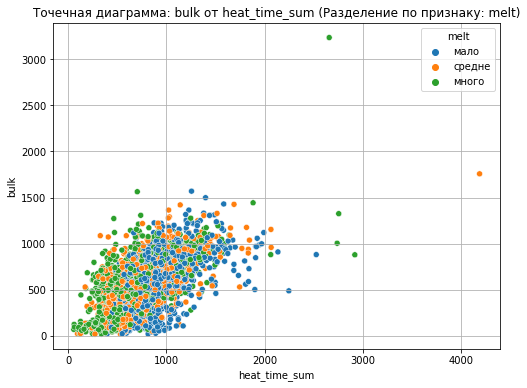

In [106]:
plot_scatter(data=df, x='heat_time_sum', y='bulk', hue='melt')

`heat_time` слегка растет в зависимости от объема материала `bulk`. Этим можно объяснять большее количество выбросов, чем в других столбцах. Видно разделение по температуре: низкая температура с большим временем нагрева.

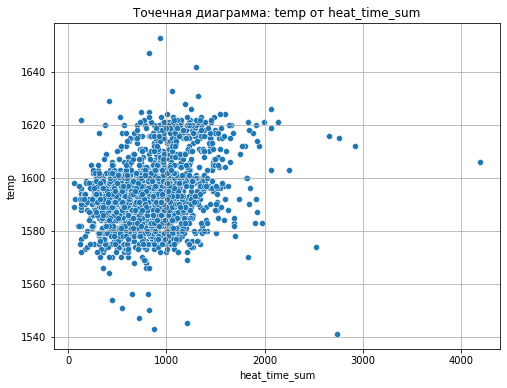

In [107]:
plot_scatter(data=df, x='heat_time_sum', y='temp')

Температура живет отдельно от времени нагрева.

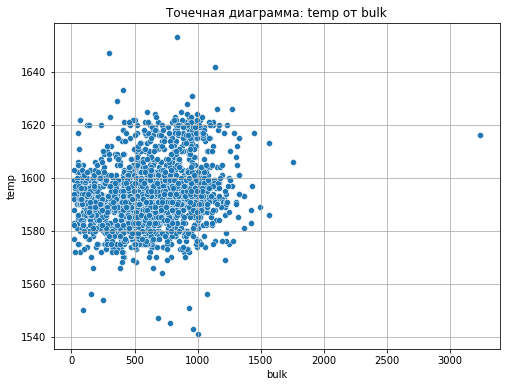

In [108]:
plot_scatter(data=df, x='bulk', y='temp')

Количество материала тоже не сильно коррелирует с температурой.

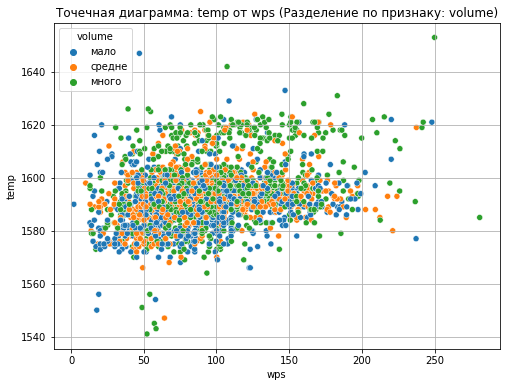

In [109]:
plot_scatter(data=df, x='wps', y='temp', hue='volume')

Температура не зависит от `wps`, но видно разделение по объему.

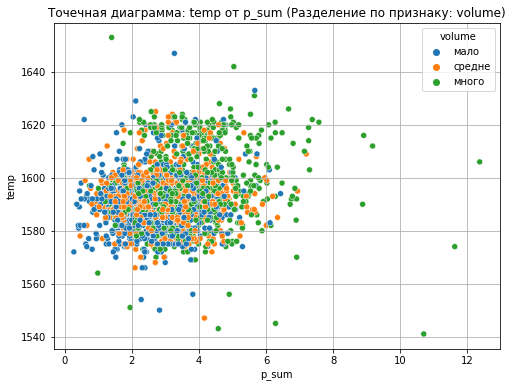

In [110]:
plot_scatter(data=df, x='p_sum', y='temp', hue='volume')

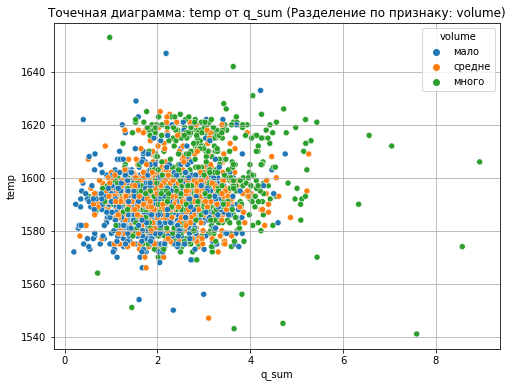

In [111]:
plot_scatter(data=df, x='q_sum', y='temp', hue='volume')

Мощности почти не влияют на температуру.

Такое странное поведение температуры можно объяснить способом ее получения. Температура снимается несколько раз, а мы смотрим на последнее значение. Таким образом, если на заводе есть какой-нибудь режим работы, то мы видим на графике результат возращения температуры к заданным значениям (расплавили и нагрели (T выросла) - добавили присадок (Т упала) - продолжили нагрев (Т выросла)). На графиках мощностей видно, что мощность все-таки слегка зависит от объема поданного материала.

In [112]:
df

,key,first_temp,temp,heat_time_sum,heat_time_mean,heat_time_max,heat_time_min,p_sum,p_mean,p_max,...,bulk_count,melt,volume,bps,wps,bps_cat,wps_cat,wire_cat,bulk_cat,heat_time_cat
0,1,1571.0,1613.0,1098.0,219.600000,365.0,148.0,3.036730,0.607346,0.867133,...,5.0,мало,средне,110.600000,60.059998,нормально,медленно,мало,средний,очень большой
1,2,1581.0,1602.0,811.0,202.750000,338.0,126.0,2.139408,0.534852,0.786322,...,5.0,средне,средне,116.400000,96.052315,нормально,нормально,мало,средний,большой
2,3,1596.0,1599.0,655.0,131.000000,280.0,65.0,4.063641,0.812728,1.222963,...,5.0,средне,средне,108.800000,91.160157,нормально,нормально,мало,средний,средний
3,4,1601.0,1625.0,741.0,185.250000,278.0,99.0,2.706489,0.676622,0.887855,...,5.0,много,средне,119.000000,89.063515,нормально,нормально,мало,средний,средний
4,5,1576.0,1602.0,869.0,217.250000,415.0,71.0,2.252950,0.563238,0.892957,...,5.0,мало,средне,116.800000,49.176398,нормально,медленно,мало,средний,большой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,723.0,180.750000,234.0,99.0,3.168133,0.792033,1.055713,...,6.0,мало,много,119.833333,89.150879,нормально,нормально,мало,большой,средний
2471,2496,1554.0,1591.0,940.0,156.666667,228.0,104.0,4.174918,0.695820,1.309449,...,6.0,мало,много,132.666667,114.179527,нормально,быстро,средне,очень большой,большой
2472,2497,1571.0,1589.0,569.0,189.666667,207.0,156.0,3.605239,1.201746,1.270521,...,5.0,мало,средне,133.000000,51.567362,нормально,медленно,средне,большой,малый
2473,2498,1591.0,1594.0,750.0,150.000000,256.0,41.0,3.202310,0.640462,0.999939,...,6.0,средне,много,122.166667,118.110717,нормально,быстро,средне,большой,средний


In [113]:
spearman = df.select_dtypes(include='number').corr(method='spearman')

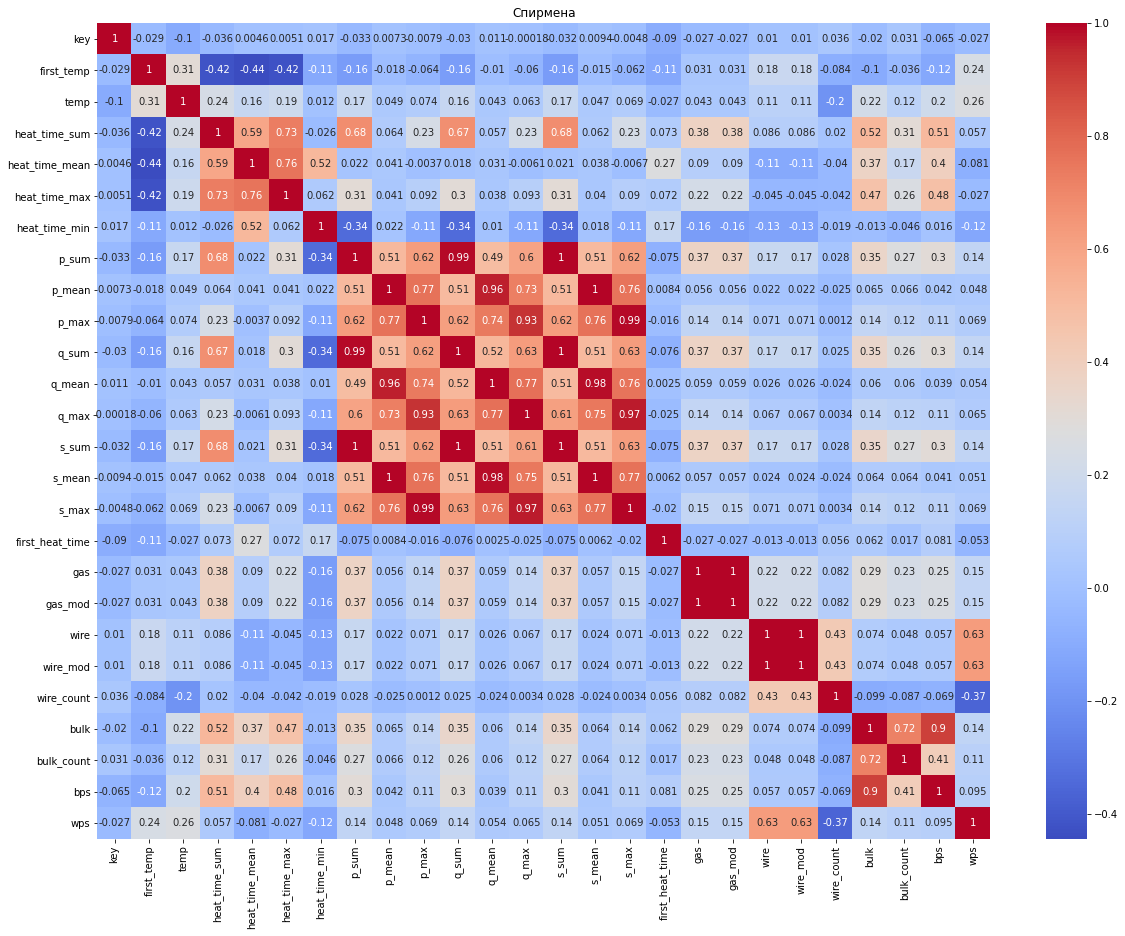

In [114]:
plt.figure(figsize=(20, 15))
sns.heatmap(spearman, annot=True, cmap='coolwarm')
plt.title("Спирмена")
plt.show()

## 5. Модель

In [115]:
r_s = 150725

6.6790

In [116]:
X = df.drop(['key', 'temp', 'q_mean', 'q_max', 'p_mean', 'p_max', 's_mean', 's_max', 'gas'], axis=1)
y = df['temp']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,          
    random_state=r_s,        
    shuffle=True            
)

In [118]:
cat_features = X_train.select_dtypes(exclude='number').columns.tolist()
num_cols = X_train.select_dtypes(include='number').columns.tolist()

Разделим пайплайн, чтобы RandSearch гарантированно прошелся по каждой модели.

In [119]:
cat_pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_xgb = ColumnTransformer([
    ('cat', cat_pipe_xgb, cat_features),
    ('num', 'passthrough', num_cols)
])

cv = KFold(n_splits=5, shuffle=True, random_state=r_s)

In [ ]:
pipe_cb = Pipeline([
    ('preprocessor', 'passthrough'),
    ('model', CatBoostRegressor())
])

params_cb = {
    'model': [CatBoostRegressor(verbose=0, random_state=r_s, cat_features=cat_features)],
    'model__depth': [4, 6, 8, 10],
    'model__iterations': [175, 200, 225],
    'model__learning_rate': [0.04, 0.05, 0.08, 0.1, 0.15],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__bagging_temperature': [0, 1, 5],
    'preprocessor': ['passthrough']
}

search_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=params_cb,
    n_iter=1,
    scoring='neg_mean_absolute_error',
    cv=cv,
    random_state=r_s,
    n_jobs=-1,
    verbose=2
)
search_cb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END model=<catboost.core.CatBoostRegressor object at 0x7f0d81478550>, model__bagging_temperature=1, model__depth=4, model__iterations=200, model__l2_leaf_reg=1, model__learning_rate=0.05, preprocessor=passthrough; total time=   1.8s
[CV] END model=<catboost.core.CatBoostRegressor object at 0x7f0d81478550>, model__bagging_temperature=1, model__depth=4, model__iterations=200, model__l2_leaf_reg=1, model__learning_rate=0.05, preprocessor=passthrough; total time=   1.4s
[CV] END model=<catboost.core.CatBoostRegressor object at 0x7f0d81478550>, model__bagging_temperature=1, model__depth=4, model__iterations=200, model__l2_leaf_reg=1, model__learning_rate=0.05, preprocessor=passthrough; total time=   1.5s
[CV] END model=<catboost.core.CatBoostRegressor object at 0x7f0d81478550>, model__bagging_temperature=1, model__depth=4, model__iterations=200, model__l2_leaf_reg=1, model__learning_rate=0.05, preprocessor=passthrough; total ti

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=150725, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor', 'passthrough'),
                                             ('model',
                                              <catboost.core.CatBoostRegressor object at 0x7f0d814781f0>)]),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'model': [<catboost.core.CatBoostRegressor object at 0x7f0d81478550>],
                                        'model__bagging_temperature': [0, 1, 5],
                                        'model__depth': [4, 6, 8, 10],
                                        'model__iterations': [175, 200, 225],
                                        'model__l2_leaf_reg': [1, 3, 5, 7],
                                        'model__learning_rate': [0.04, 0.05,
                                                                 0.08, 0.1,
                                                                 0.15],


In [123]:
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor_xgb),
    ('model', XGBRegressor())
])

params_xgb = {
    'model': [XGBRegressor(random_state=r_s, tree_method='hist')],
    'model__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'model__n_estimators': [50, 100, 150, 200, 250, 300],
    'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15],
    'model__subsample': [0.6, 0.8, 1.0],
}

search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=params_xgb,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=cv,
    random_state=r_s,
    n_jobs=-1,
    verbose=2
)
search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=150725, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method='hist', validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=200, model__subsample=0.8; total time=  34.4s
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_by

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=150725, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ordinal',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['melt',
                                                        

pipe_hgb = Pipeline([
    ('preprocessor', preprocessor_xgb),
    ('model', HistGradientBoostingRegressor())
])

params_hgb = {
    'model__max_iter': [100, 150, 200, 225],
    'model__max_depth': [2, 4, 6, 8],
    'model__learning_rate': [0.008, 0.01, 0.02, 0.05, 0.1]
}

search_hgb = RandomizedSearchCV(
    pipe_hgb,
    param_distributions=params_hgb,
    n_iter=75,
    scoring='neg_mean_absolute_error',
    cv=cv,
    random_state=r_s,
    n_jobs=-1,
    verbose=2
)
search_hgb.fit(X_train, y_train)

In [121]:

pipe_lgb = Pipeline([
    ('preprocessor', preprocessor_xgb),
    ('model', LGBMRegressor(verbose=-1))
])

params_lgb = {
    'model__n_estimators': [100, 150, 200, 250],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.005, 0.01, 0.02, 0.05],
    'model__num_leaves': [15, 31, 63],
    'model__min_child_samples': [5, 10, 20],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

search_lgb = RandomizedSearchCV(
    pipe_lgb,
    param_distributions=params_lgb,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=cv,
    random_state=r_s,
    n_jobs=-1,
    verbose=2
)
search_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.005, model__max_depth=3, model__min_child_samples=5, model__n_estimators=100, model__num_leaves=31, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.005, model__max_depth=3, model__min_child_samples=5, model__n_estimators=100, model__num_leaves=31, model__subsample=0.8; total time=   1.7s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.005, model__max_depth=3, model__min_child_samples=5, model__n_estimators=100, model__num_leaves=31, model__subsample=0.8; total time=   2.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.005, model__max_depth=3, model__min_child_samples=5, model__n_estimators=100, model__num_leaves=31, model__subsample=0.8; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.005, model__max_depth=3, model__min_child_samples=5, model__n_estimat

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=150725, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ordinal',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['melt',
                                                        

In [126]:
searches = {
    'CatBoost': search_cb,
    'XGBoost': search_xgb,
    'LGB': search_lgb
}

In [127]:
#Функция принимает на вход словарь и выдает таблицу с лучшими моделями и метриками.
def mae(dict, X_test, y_test):
    rows = []
    for name, search in dict.items():
        mae_cv = -search.best_score_
        rows.append({'Модель': name, 'Метрика на кросс-валидации': mae_cv, 'Search': search})

    results_df = pd.DataFrame(rows).sort_values(by='Метрика на кросс-валидации')

    best_search = results_df.iloc[0]['Search']
    best_model_name = results_df.iloc[0]['Модель']

    y_pred = best_search.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)

    return results_df.reset_index(drop=True), best_model_name, mae_test

In [128]:
results, best_model_name, mae_test = mae(searches, X_test, y_test)

display(results)
print(f'Лучшая модель: {best_model_name}')
print(f'MAE лучшей модели на тесте: {mae_test:.4f}')

,Модель,Метрика на кросс-валидации,Search
0,LGB,6.543318,"RandomizedSearchCV(cv=KFold(n_splits=5, random..."
1,CatBoost,6.570481,"RandomizedSearchCV(cv=KFold(n_splits=5, random..."
2,XGBoost,6.646732,"RandomizedSearchCV(cv=KFold(n_splits=5, random..."


Лучшая модель: LGB
MAE лучшей модели на тесте: 6.7632


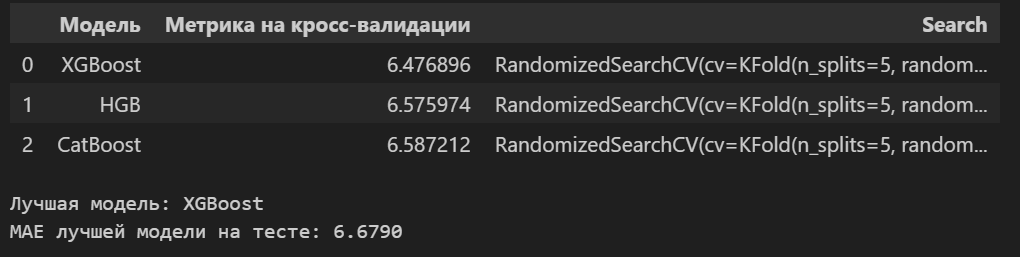


Лучшая модель: *XGBoost*.

Метрика на тесте: 6.68 градусов.

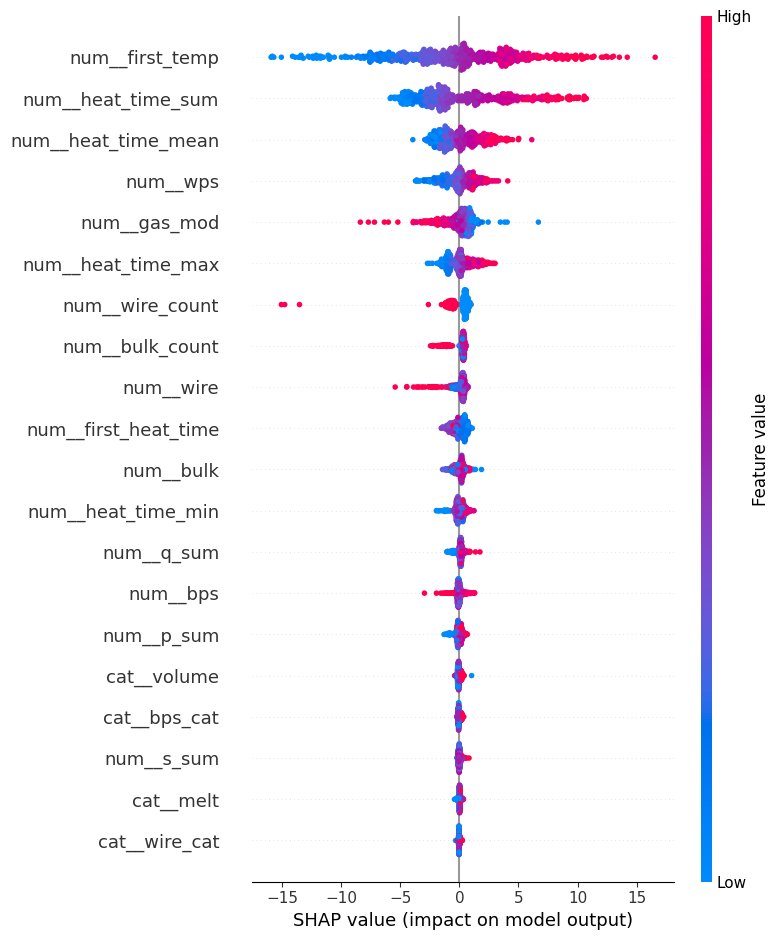

In [230]:
model = search_xgb.best_estimator_.named_steps['model']
preprocessor = search_xgb.best_estimator_.named_steps['preprocessor']

X_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

1. `first_temp` - оказывает наибольшее влияние на модель. Наиболее сложный признак. Я его воспринимаю как температура заготовки перед введением всего остального. В целом с температурой наименее понятная ситуация. Было ли достигнуто тепловое равновесие? Где конкретно измерялась температура? Я все еще считаю, что эта задача может быть решена либо аналитечески, либо методами математического моделирования.
2. `heat_time_sum`
3. `heat_time_mean`
4. `num_wps`
5. `gas_mod`

## Выводы

1. Загружено 7 массивов разных размеров с общим ключом для объединения.

2. Анализ массивов по отельности:
    1. *df_arc*: Исправлен один выброс, переименованы столбцы, добавлены новыe признаки: `heat_time` - время работы дуги, `s`. Выбросов мало и локализованы они недалеко от третьего квантиля. Что-то потом можно удалить.

    2. *df_bulk*: Создано два признака: `bulk` - общее количество материала, `bulk_count` - количество "источников", подающих материал. Номерные столбцы удалены. Распределения значений близко к нормальному. Есть незначительное количество выбросов.

    3. *df_bulk_time*: Не нашел применение этим данным.

    4. *df_gas*: Небольшое количество выбросов, добален признак `gas_mod`, приводящий данные к нормальному распределению.

    5. *df_temp*: Температура сосредоточена довольно кучно, за исключением одной точки. Это объяснятся режимом самого процесса. Есть небольшое количество выбросов. Создан целевой признак `temp` и признак по первой температуре в партии `first_temp`.

    6. *df_wire*: Просуммированы все проволочные материалы, посчитаны источники. Выбросов мало. Создан признак `wire_mod` с распределением близким к нормальному.

    7. *df_wire_time*: Не нашел применение этим данным.

3. Столбцы объединены по общему ключу. Размер конечного массива 2329 на 19. Массивы присоединялись по левому типу к *df_temp*.

4. Температура не коррелирует ни с одном из признаков явным образом. Такое странное поведение температуры можно объяснить способом ее получения. Температура снимается несколько раз, а мы смотрим на последнее значение. Таким образом, если на заводе есть какой-нибудь режим работы, то мы видим на графике результат возращения температуры к заданным значениям (расплавили (T выросла) - добавили присадок (Т упала) - продолжили нагрев (Т выросла)). На графиках мощностей видно, что мощность все-таки слегка зависит от объема поданного материала. 
Из-за мультиколлинеарности при подборе гиперпараметров удалены следующие признаки: `q_mean`, `q_max`, `p_mean`, `p_max`, `s_mean`, `s_max`, `gas`.

5. Обучено три модели: *CatBoost*, *XGBoost*, *LightGBM*. 

    Лучшая модель на кросс-валидации: *XGBoost*.

    *MAE* лучшей модели на тестовых данных: 6.68 градусов.

6. Топ-5 признаков:
    1. `first_temp` - оказывает наибольшее влияние на модель. Наиболее сложный признак. Я его воспринимаю как температура заготовки перед введением всего остального. 
    2. `heat_time_sum`
    3. `heat_time_mean` - две вариации времени нагрева. Как я понимаю, довольно воспроизводимый в реальных условиях признак. Можно заранее решить, сколько будет длиться нагрев. Разделить этот нагрев на несколько итераций и получить остальные свзянные признаки.
    4. `num_wps` - зная предыдущие параметры, можно получить и этот признак.
    5. `gas_mod` - аналогично.

7. Общие выводы: 
    После очистки данных, добавления и удаления новых признаков, в модель попало 24 признака. Обучено три модели, лучшей из которой оказался *XGBoost*, который достиг поставленного условия (*MAE* $\leq$ 6.9). Ключевым оказался созданный признак `first_temp` - первая измеренная температура заготовки. 

    Говоря о самом производстве, все еще непонятно, где конкретно измерялась температура, было ли достигнуто тепловое равновесие в момент измерения. Это важно в контексте поставленного условия - 6.9 градусов максимальная ошибка. Я склоняюсь к тому, что эта задача более эффективно решается математического моделирования либо аналитически. 

    Для повышения точности работы модели важно знать больше параметров вводимых веществ. Теплоемкости, температуры и так далее. Помимо прямой задачи - определение температуры заготовки и влияния тех или иных параметров, модель еще может решать косвенную задачу - определение износа оборудования.